In [75]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
plt.rcParams['font.size'] = '16'

with open("s_res.pkl", "rb") as fp:   # Unpickling
    s_edge = pickle.load(fp)

with open("../../Eqt_ori_result/results/s_res.pkl", "rb") as fp:   # Unpickling
    s_ori = pickle.load(fp)

with open("../../EQT_ori/results/s_res.pkl", "rb") as fp:   # Unpickling

    s_fine = pickle.load(fp)
with open("p_res.pkl", "rb") as fp:   # Unpickling    
    p_edge = pickle.load(fp)
    
with open("../../Eqt_ori_result/results/p_res.pkl", "rb") as fp:   # Unpickling
    p_ori = pickle.load(fp)

with open("../../EQT_ori/results/p_res.pkl", "rb") as fp:   # Unpickling
    p_fine = pickle.load(fp)
    
th=0.5


In [76]:


def build_res(res,np_rg):
    df = pd.DataFrame( columns=['match','miss','false','add','delta','th'])

    for th_p in tqdm.tqdm(np_rg):
        delta_all = []
        miss=0
        match=0
        false=0
        add=0

        for i in res:

            p= i[0]
            p_prob=i[1]
            target_p=i[2]
            p=p[p_prob>=th_p]

            if target_p<0:
                false += len(p)
            elif target_p==0:
                if len(p)>1:
                    add += 1
                    false += len(p)-1

            else:
                flag=1
                for i in p:
                    delta= i-target_p
                    if abs(delta)<th:
                        delta_all.append(delta)
#                         match+=1
                        flag=0
                    else:
                        false+=1
                match+=(1-flag)
                miss+=flag
                
        df_tmp = {'match': match, 'miss': miss, 
               'false': false,  'add': add,
               'delta':delta_all,'th':th_p}

        df= df.append(df_tmp, ignore_index = True)
    # TP/TP+FP
    df['precision'] = (df.match+1)/(df.match+df.false+1)
    # TP/TP+FN
    df['recall'] = (df.match+1)/(df.match+df.miss+1)

    df['F1'] = 2*df['precision']*df['recall']/(df['precision']+df['recall'])
    
    return df



# df_p=build_res(p_res,np.arange(0.05,0.85,0.01))
# df_s=build_res(s_res,np.arange(0.13,0.5,0.01))

df_p_edge=build_res(p_edge,np.arange(0.05,0.9,0.01))
df_s_edge=build_res(s_edge,np.arange(0.05,0.8,0.01))

df_p_ori=build_res(p_ori,np.arange(0.01,0.9,0.01))
df_s_ori=build_res(s_ori,np.arange(0.01,0.6,0.01))

df_p_fine=build_res(p_fine,np.arange(0.05,0.9,0.01))
df_s_fine=build_res(s_fine,np.arange(0.05,0.8,0.01))

100%|███████████████████████████████████████████| 75/75 [01:37<00:00,  1.30s/it]


In [4]:
def snr_dist(res,th_p):
    df = pd.DataFrame( columns=['match','miss','false','add','delta','th'])

    delta_all = []
    miss=[]
    match=[]
    false=[]
    add=[]

    for i in res:

        p= i[0]
        p_prob=i[1]
        target_p=i[2]
        snr = i[3]
        p=p[p_prob>=th_p]
        if snr >-10:
            if target_p<0:
                false += len(p)*[snr]
            elif target_p==0:
                if len(p)>1:
                    add += [snr]
                    false += (len(p)-1)*[snr]

            else:
                flag=1
                for i in p:
                    delta= i-target_p
                    if abs(delta)<th:
                        delta_all.append(delta)
                        flag=0
                    else:
                        false+=[snr]
                        
                miss+=flag*[snr]
                match+=(1-flag)*[snr]
    df_tmp = {'match': match, 'miss': miss, 
           'false': false,  'add': add,
           'delta':delta_all,'th':th_p}

    
    return df_tmp


df_edge_p =snr_dist(p_edge,0.39)
df_ori_p =snr_dist(p_ori,0.05)
df_fine_p=snr_dist(p_fine,0.64)

df_edge_s =snr_dist(s_edge,0.28)
df_ori_s =snr_dist(s_ori,0.03)
df_fine_s=snr_dist(s_fine,0.40)


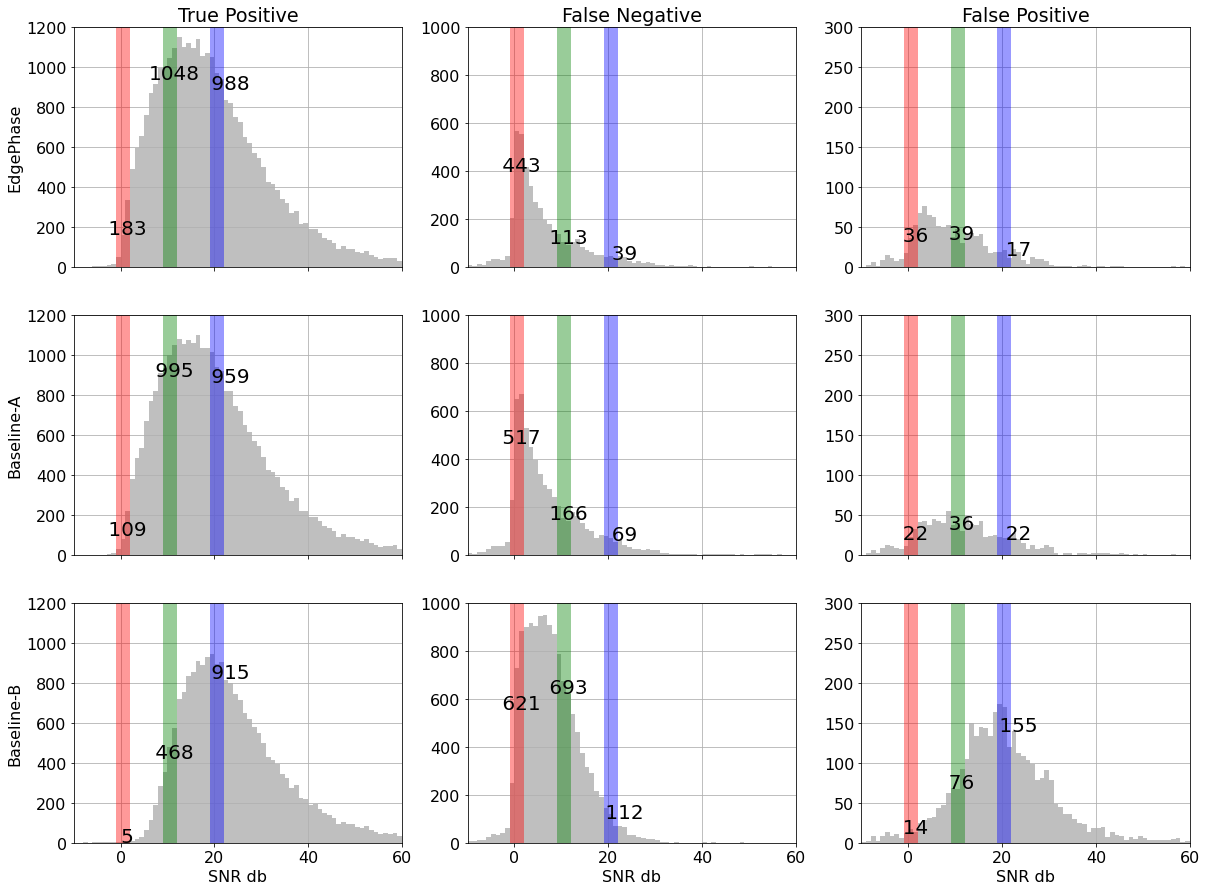

In [72]:
# plt.hist(df_edge_p['match'])
plt.figure(figsize=(20,15))
k=1
color = ['gray','gray','gray']
for df in [df_edge_p,df_fine_p,df_ori_p]:
    for label in ['match','miss','false']:
        plt.subplot(3,3,k)
        plt.grid(visible=True)

        if k==1:
            plt.title('True Positive')
            plt.ylabel('EdgePhase')
        if k==2:
            plt.title('False Negative')
        if k==3:
            plt.title('False Positive')
        if k==4:
            plt.ylabel('Baseline-A')
        if k==7:
            plt.ylabel('Baseline-B')

            
        cl = color[k%3]
        
        if k%3==1:
            plt.ylim([0,1200])

        elif k%3==2:
            plt.ylim([0,1000])
        else:
            plt.ylim([0,300])
        bin_data=plt.hist(df[label],bins=np.arange(-10,61,1), color=cl,alpha=0.5)


        plt.xlim([-10,60])
        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        plt.vlines(0.5,0,y_max,color='r',linewidth=14,alpha=0.4)
        plt.vlines(10.5,0,y_max,color='g',linewidth=14,alpha=0.4)
        plt.vlines(20.5,0,y_max,color='b',linewidth=14,alpha=0.4)

        if k <=6:
#             plt.xticks([])
            axes.xaxis.set_ticklabels([])
        plt.text(-4,np.sum(bin_data[0][9:12])*0.3,"{:4.0f}".format(np.sum(bin_data[0][9:12])/3),fontsize=20)

        plt.text(6,np.sum(bin_data[0][19:22])*0.3,"{:4.0f}".format(np.sum(bin_data[0][19:22])/3),fontsize=20)
        plt.text(18,np.sum(bin_data[0][29:32])*0.3,"{:4.0f}".format(np.sum(bin_data[0][29:32])/3),fontsize=20)

        if k > 6:
            plt.xlabel('SNR db')
        k+=1
plt.savefig('P-phases.png')

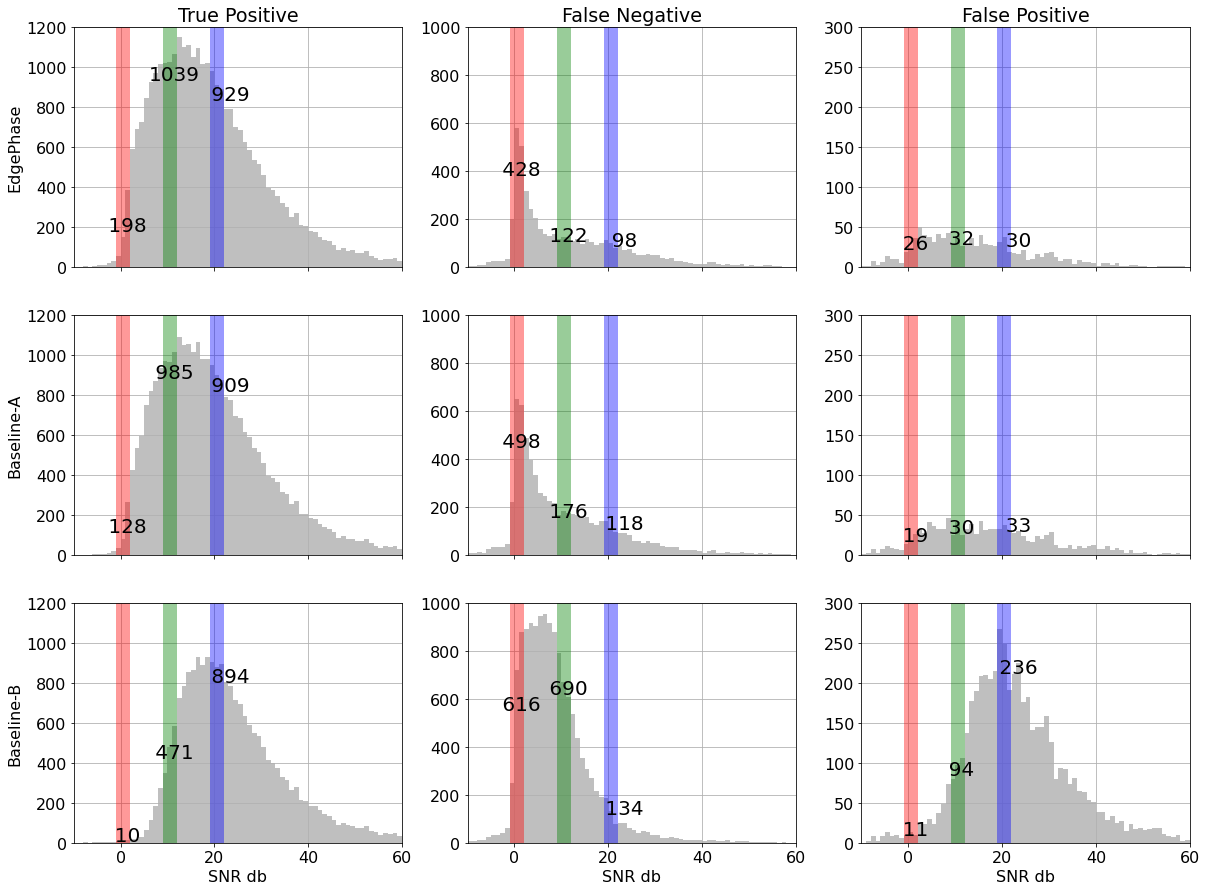

In [73]:
plt.figure(figsize=(20,15))
k=1
color = ['gray','gray','gray']
for df in [df_edge_s,df_fine_s,df_ori_s]:
    for label in ['match','miss','false']:
        plt.subplot(3,3,k)
        plt.grid(visible=True)

        if k==1:
            plt.title('True Positive')
            plt.ylabel('EdgePhase')
        if k==2:
            plt.title('False Negative')
        if k==3:
            plt.title('False Positive')
        if k==4:
            plt.ylabel('Baseline-A')
        if k==7:
            plt.ylabel('Baseline-B')

            
        cl = color[k%3]
        
        if k%3==1:
            plt.ylim([0,1200])

        elif k%3==2:
            plt.ylim([0,1000])
        else:
            plt.ylim([0,300])
        bin_data=plt.hist(df[label],bins=np.arange(-10,61,1), color=cl,alpha=0.5)


        plt.xlim([-10,60])
        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        plt.vlines(0.5,0,y_max,color='r',linewidth=14,alpha=0.4)
        plt.vlines(10.5,0,y_max,color='g',linewidth=14,alpha=0.4)
        plt.vlines(20.5,0,y_max,color='b',linewidth=14,alpha=0.4)

        if k <=6:
#             plt.xticks([])
            axes.xaxis.set_ticklabels([])
        plt.text(-4,np.sum(bin_data[0][9:12])*0.3,"{:4.0f}".format(np.sum(bin_data[0][9:12])/3),fontsize=20)

        plt.text(6,np.sum(bin_data[0][19:22])*0.3,"{:4.0f}".format(np.sum(bin_data[0][19:22])/3),fontsize=20)
        plt.text(18,np.sum(bin_data[0][29:32])*0.3,"{:4.0f}".format(np.sum(bin_data[0][29:32])/3),fontsize=20)

        if k > 6:
            plt.xlabel('SNR db')
        k+=1
plt.savefig('S-phases.png')

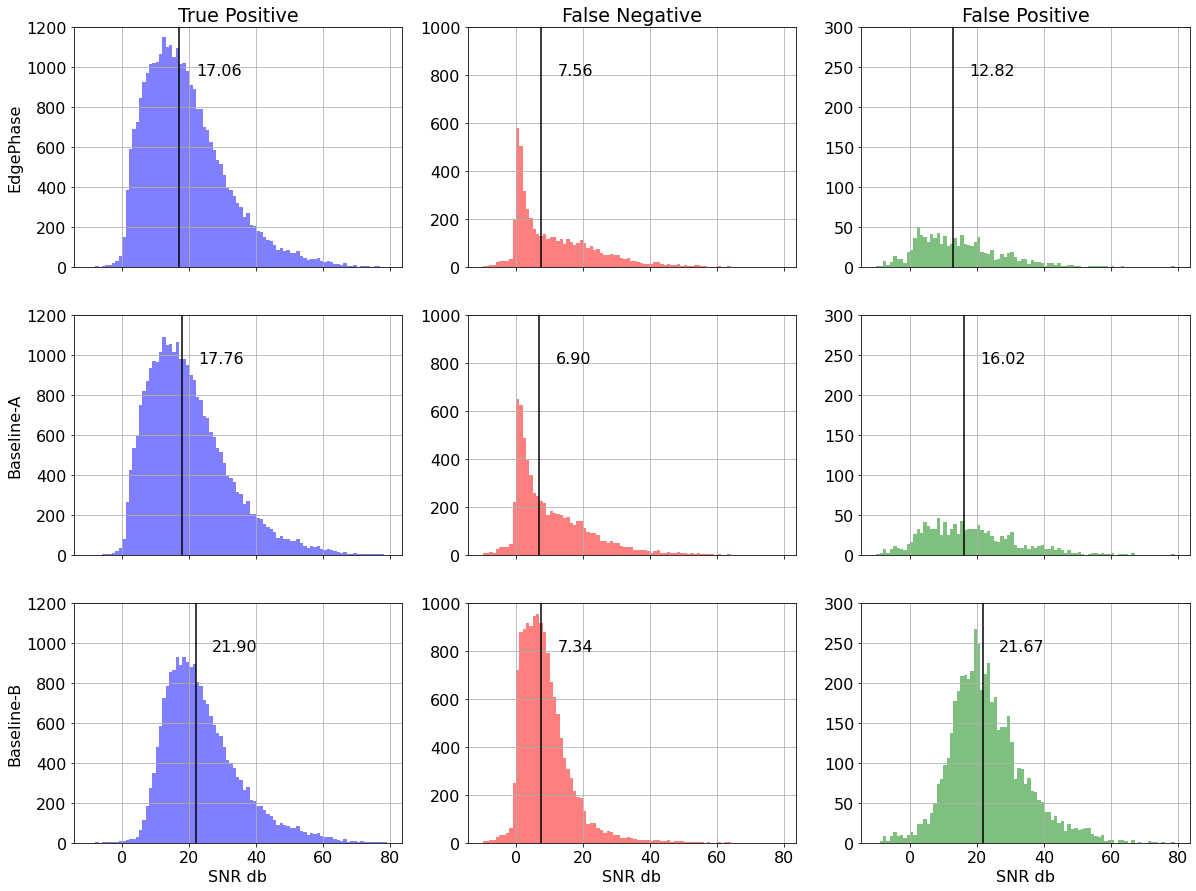

In [40]:
# plt.hist(df_edge_p['match'])
plt.figure(figsize=(20,15))
k=1
color = ['g','b','r']

for df in [df_edge_s,df_fine_s,df_ori_s]:
    for label in ['match','miss','false']:
        plt.subplot(3,3,k)
        plt.grid()
        if k==1:
            plt.title('True Positive')
            plt.ylabel('EdgePhase')
        if k==2:
            plt.title('False Negative')

        if k==3:
            plt.title('False Positive')

        if k==4:
            plt.ylabel('Baseline-A')
        if k==7:
            plt.ylabel('Baseline-B')
     
        if k%3==1:
            plt.ylim([0,1200])

        elif k%3==2:
            plt.ylim([0,1000])
        else:
            plt.ylim([0,300])
     
        cl = color[k%3]
        plt.hist(df[label],bins=np.arange(-10,80,1), color=cl,alpha=0.5)
        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        plt.vlines(np.median(df[label]),0,y_max,color='k')
        if k <=6:
#             plt.xticks([])
            axes.xaxis.set_ticklabels([])
        plt.text(np.median(df[label])+5,y_max*0.8,"{:4.2f}".format(np.median(df[label])))
        if k > 6:
            plt.xlabel('SNR db')
        k+=1
    
plt.savefig('S-phases.png')

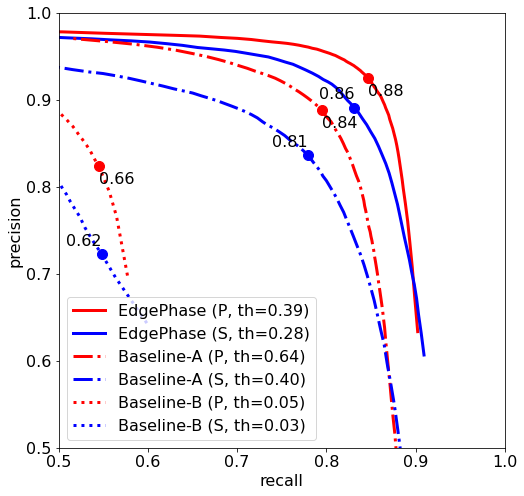

In [78]:
def plot_fig(df1,df2,linetype,name):
    
    # precision=tp/(tp+fp)
    # recall = tp/(tp+fn)
    tmp1=df1['F1'].max()
    record1=df1[df1['F1']==tmp1]
    tmp2=df2['F1'].max()
    record2=df2[df2['F1']==tmp2]
#     print(record1, record2)
    # print(precision, recall,F1)
#     plt.figure(figsize=(5,12))
#     plt.subplot(311)

#     if name=='Baseline-B':
#         record2.th[0]=0.06
    plt.plot(df1.recall,df1.precision,linetype,color='r',linewidth=3,label=name+' (P, th={:4.2f})'.format(list(record1.th)[0]))
    plt.plot(record1.recall,record1.precision,'ro',markersize=10)
#     plt.text(record1.recall,record1.precision+0.03,"Th={:4.2f}".format(list(record1.th)[0]),color='k')
    plt.text(record1.recall,record1.precision-0.02,"{:4.2f}".format(list(record1.F1)[0]),color='k')

    plt.plot(df2.recall,df2.precision,linetype,color='b',linewidth=3,label=name+' (S, th={:4.2f})'.format(list(record2.th)[0]))
    plt.plot(record2.recall,record2.precision,'bo',markersize=10)
#     plt.text(record2.recall-0.03,record2.precision-0.02,"Th={:4.2f}".format(list(record2.th)[0]) ,color='k')
    plt.text(record2.recall-0.04,record2.precision+0.01,"{:4.2f}".format(list(record2.F1)[0]) ,color='k')

    
#     plt.subplot(312)
#     plt.hist(record1.delta,color='r',bins=np.arange(-0.5,0.5,0.01),density=True)
#     arr=np.array(list(record1.delta))
#     print(np.mean(abs(arr)))
#     plt.text(-0.4,5.5,'mean: '+"{:6.2f}".format(np.mean(arr)),color='k')
#     plt.text(-0.4,5,'std: '+"{:6.2f}".format(np.std(arr)),color='k')

#     plt.xlim([-0.5,0.5])

#     plt.subplot(313)
#     plt.hist(record2.delta,color='b',bins=np.arange(-0.5,0.5,0.01),density=True)
#     arr=np.array(list(record2.delta))
#     print(np.mean(abs(arr)))

#     plt.text(-0.4,3.3,'mean: '+"{:6.2f}".format(np.mean(arr)),color='k')
#     plt.text(-0.4,3,'std: '+"{:6.2f}".format(np.std(arr)),color='k')
#     plt.xlim([-0.5,0.5])

plt.figure(figsize=(8,8))
plot_fig(df_p_edge,df_s_edge,'-','EdgePhase')
plot_fig(df_p_fine,df_s_fine,'-.','Baseline-A')
plot_fig(df_p_ori,df_s_ori,':','Baseline-B')
plt.legend()
plt.xlim([0.5,1.00])
plt.ylim([0.5,1.00])
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('Fig_2.png')
plt.savefig('Fig_2.pdf')

In [206]:
snr_stead=[]

df=pd.read_csv('/home/tian_feng/UCLA/merged.csv')
for idx in tqdm.tqdm(range(len(df))):
    if df['trace_category'][idx] == 'earthquake_local':
        if df['trace_name'][idx] in test_set:
            snr_stead.append(df['snr_db'][idx])

100%|████████████████████████████████| 1265657/1265657 [21:58<00:00, 959.71it/s]


In [ ]:
# measure the snr 
import h5py

input_hdf5='/home/tian_feng/UCLA/merged.hdf5'

test_set=np.load('/home/tian_feng/UCLA/gMLP_phase/gMLP_phase/EQTransformer/ModelsAndSampleData/test.npy')
fl  = h5py.File(input_hdf5, 'r')
snr_stead=[]
for ID in tqdm.tqdm(test_set):
    dataset = fl.get('data/'+str(ID))
    if dataset.attrs['trace_category'] == 'earthquake_local':
#         spt = int(dataset.attrs['p_arrival_sample']);
#         sst = int(dataset.attrs['s_arrival_sample']);
        snr = dataset.attrs['snr_db'];
        snr_stead.append(snr)
#         waveform=np.array(dataset)
#         s=np.percentile(abs(waveform[sst:min(sst+300,6000)]), 95, axis=0)
#         p=np.percentile(abs(waveform[max(0,spt-500):spt-100]), 95, axis=0)

# #         print(s,p)
#         snr2=10*np.log10(s**2/p**2)
#         snr2_cluster.append(snr2)

In [3]:
folder = '/home/tian_feng/UCLA/gMLP_phase/gMLP_phase/Dataset_builder/'
test_set=np.load(folder+'test.npy')

In [172]:
folder = '/home/tian_feng/UCLA/gMLP_phase/gMLP_phase/Dataset_builder/'
test_set=np.load(folder+'test.npy')
snr_new=[]
for ID in tqdm.tqdm(test_set[:]):
    name = ID.split('/')
    if name[1]=='events':
        with open(folder+ID, "rb") as fp:   # Unpickling
            file = pickle.load(fp)
            for sta in file:
                waveform=file[sta]['waveforms']
                starttime =waveform[0].stats.starttime
                waveform=np.array(waveform).T
                if waveform.ndim!=2:
                      continue
                spt=file[sta]['phase_p']
                sst =file[sta]['phase_s']
                if len(spt)>0 and len(sst)>0:
                    spt =int((spt[0]-starttime)*100)
                    sst= int((sst[0]-starttime)*100)
                    if spt>0 and sst>0 and sst<waveform.shape[0]:
                        s=np.percentile(abs(waveform[sst:min(sst+300,waveform.shape[0])]), 95, axis=0)
                        p=np.percentile(abs(waveform[max(0,spt-500):spt-100]), 95, axis=0)
                        snr=10*np.log10(s**2/p**2)
                        snr_new.append(snr)

  1%|▎                                        | 21/2854 [00:01<02:07, 22.17it/s]/home/tian_feng/anaconda3/envs/eqt/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
100%|███████████████████████████████████████| 2854/2854 [04:30<00:00, 10.56it/s]


In [260]:
a = []
for i in snr_new:
    for k in i:
        if k>0:
            a.append(k)
b = []
for i in snr_stead:    
    i=(i.rstrip(']').lstrip('[').split(' '))
    for k in i:
        try:
            k=float(k)
            if k>0:
                b.append(k)
        except:
            continue
            

# plt.hist(b[:,0])

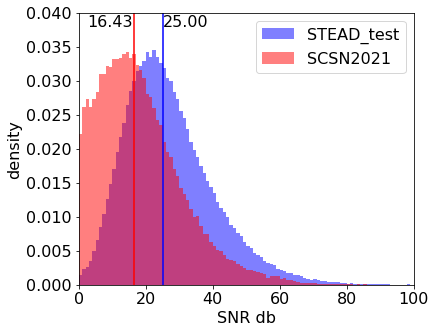

In [273]:
a=np.array(a)
b=np.array(b)
plt.figure(figsize=(6,5))
plt.hist(b,bins=np.arange(0,100,1),density=True,color='b',alpha=0.5,label='STEAD_test')
plt.vlines(np.median(b),0,0.05,color='b')
plt.text(np.median(b),0.038,"{:4.2f}".format(np.median(b)))

plt.hist(a,bins=np.arange(0,100,1),density=True,color='r',alpha=0.5,label='SCSN2021')
plt.vlines(np.median(a),0,0.05,color='r')
plt.text(np.median(a)-14,0.038,"{:4.2f}".format(np.median(a)))

plt.xlim([0,100])
plt.ylim([0,0.04])
plt.xlabel('SNR db')
plt.ylabel('density')

plt.legend()
plt.savefig('datasetcomapre')

In [180]:
a

array([array([ 24.63640219,  23.39324816,  25.71391938]),
       array([ 25.13243449,  23.88919335,  26.08185701]),
       array([ 15.54130034,  12.6744728 ,  11.89838582]), ...,
       array([ 5.66796243,  8.69496437,  6.48474634]),
       array([ 6.94004279,  8.90204809,  5.66393687]),
       array([-0.71331112, -0.37197275, -0.58232585])], dtype=object)

In [124]:
!pwd

/home/tian_feng/UCLA/gMLP_phase/gMLP_phase/GNN/Try_EQT_2/results


In [127]:
import obspy
st=obspy.read('/home/tian_feng/UCLA/Greece-2020-10-30/Data2/20201117/HL.EAG2.mseed')

In [128]:
st

3 Trace(s) in Stream:
HL.EAG2..HHE | 2020-11-17T00:00:00.000000Z - 2020-11-18T00:00:00.000000Z | 100.0 Hz, 8640001 samples
HL.EAG2..HHN | 2020-11-17T00:00:00.000000Z - 2020-11-18T00:00:00.000000Z | 100.0 Hz, 8640001 samples
HL.EAG2..HHZ | 2020-11-17T00:00:00.000000Z - 2020-11-18T00:00:00.000000Z | 100.0 Hz, 8640001 samples

In [130]:
st[0].stats

         network: HL
         station: EAG2
        location: 
         channel: HHE
       starttime: 2020-11-17T00:00:00.000000Z
         endtime: 2020-11-18T00:00:00.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 21560, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 34144256})

In [131]:
sta=np.load('/home/tian_feng/UCLA/Greece-2020-10-30/station.npy')

In [135]:
for i in sta:
    print(i)

['4' 'ODC' 'TU' 'AYDN' '37.6608' '27.8792' '716.0' 'HHE']
['17' 'KOERI' 'KO' 'EDC' '40.3465' '27.8618' '257.0' 'HHE']
['22' 'KOERI' 'KO' 'EZN' '39.8255' '26.3247' '48.0' 'HHE']
['25' 'KOERI' 'KO' 'GEDZ' '39.0445' '29.4105' '883.0' 'HHE']
['26' 'KOERI' 'KO' 'GELI' '40.398' '26.4742' '126.0' 'HHE']
['34' 'KOERI' 'KO' 'KRBG' '40.3932' '27.2977' '79.0' 'HHE']
['41' 'KOERI' 'KO' 'MRMT' '40.609' '27.5832' '213.0' 'HHE']
['47' 'KOERI' 'KO' 'TVSB' '39.4497' '29.4615' '1090.0' 'HHE']
['56' 'KOERI' 'KO' 'GAZK' '40.747895' '27.327514' '30.0' 'HHE']
['57' 'KOERI' 'KO' 'BIGA' '40.281348' '27.150483' '60.0' 'HHE']
['61' 'KOERI' 'KO' 'YAYO' '39.6113' '27.0726' '119.0' 'HHE']
['62' 'KOERI' 'KO' 'APMY' '37.47178' '29.30178' '930.0' 'HHE']
['65' 'KOERI' 'KO' 'FETY' '36.6353' '29.0835' '200.0' 'HHE']
['7' 'KOERI' 'KO' 'BASM' '37.919364' '30.034952' '1012.0' 'HNE']
['10' 'KOERI' 'KO' 'CESE' '38.3306' '26.2997' '95.0' 'HNE']
['13' 'KOERI' 'KO' 'DATC' '36.7584' '27.6602' '94.0' 'HNE']
['14' 'KOERI' 'KO' 'DI